In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
# plt.rcParams['axes.facecolor'] = 'white'
# sns.set_style("whitegrid")
sns.set(palette="bright", font_scale=2)
# sns.color_palette("bright")
# sns.set_style("whitegrid", {'ax.right_ax.grid' : False})

In [2]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [3]:
sg_window_size, sg_order = 15, 3

In [4]:
def plot_mnist_entropy(mnist_plots_location):
    dirs = ["perf_lists_al", "perf_lists_vae", "perf_lists_vaegan"]
    labels = {
        "perf_lists_al": "Max Entropy w/o DA",
        "perf_lists_duplicate": "Max Entropy w Duplicated Samples",
        "perf_lists_vae": "Max Entropy w VAE",
        "perf_lists_vaegan": "Max Entropy w VAEGAN"
    }
    plt.tight_layout()
    plt.figure(figsize=(15, 10))
    plt.title("Test Accuracy Performance for Max Entropy on MNIST")
    plt.ylabel("Test Accuracy")
    plt.xlabel("Acquisition Iterations")
    
    with open(os.path.join(mnist_plots_location, "perf_lists_al", "uniform_perf_hist")) as f:
        uniform_val_accs = [float(line.rstrip()) for line in f]
        no_x_vals = len(uniform_val_accs)-1
        uniform_val_accs_smoothen = savitzky_golay(np.array(uniform_val_accs[1:]), sg_window_size, sg_order)
        plt.plot(np.arange(no_x_vals)+1, uniform_val_accs_smoothen, label="Uniform")
    for dir_name in dirs:
        with open(os.path.join(mnist_plots_location, dir_name, "entropy_perf_hist")) as f:
            val_accs = [float(line.rstrip()) for line in f]
        no_x_vals = len(val_accs)-1
        val_accs_smoothen = savitzky_golay(np.array(val_accs[1:]), sg_window_size, sg_order)
        plt.plot(np.arange(no_x_vals)+1, val_accs_smoothen, label=labels[dir_name])
    
    tran_mnist_res = np.load("../../mnist_max_entropy.npy")
    tran_mnist_res = tran_mnist_res[2].flatten()
    tran_mnist_res /= 100
    no_x_vals = tran_mnist_res.shape[0]
    
#     tran_mnist_res_smoothen = savitzky_golay(tran_mnist_res, sg_window_size, sg_order)
    
    plt.plot(np.arange(no_x_vals)+1, tran_mnist_res, label="Max Entropy w jointly trained VAE-ACGAN")
    plt.ylim([0.8, 1])
    plt.legend()
    plt.savefig(os.path.join(mnist_plots_location, "plots\\entropy.png"))

C:\Users\saumy\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\saumy\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.


<Figure size 432x288 with 0 Axes>

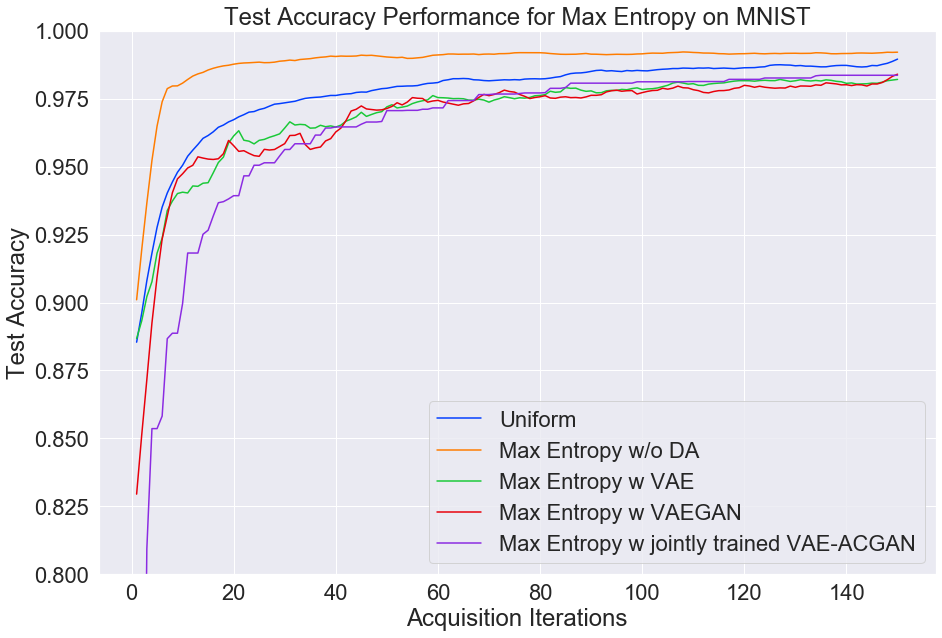

In [5]:
plot_mnist_entropy("..\\MNIST")

In [6]:
def plot_mnist_bald(mnist_plots_location):
    dirs = ["perf_lists_al", "perf_lists_vae", "perf_lists_vaegan"]
    labels = {
        "perf_lists_al": "BALD w/o DA",
        "perf_lists_duplicate": "BALD w Duplicated Samples",
        "perf_lists_vae": "BALD w VAE",
        "perf_lists_vaegan": "BALD w VAEGAN"
    }
    plt.tight_layout()
    plt.figure(figsize=(15, 10))
    plt.title("Test Accuracy Performance for BALD on MNIST")
    plt.ylabel("Test Accuracy")
    plt.xlabel("Acquisition Iterations")
    
    with open(os.path.join(mnist_plots_location, "perf_lists_al", "uniform_perf_hist")) as f:
        uniform_val_accs = [float(line.rstrip()) for line in f]
        no_x_vals = len(uniform_val_accs)-1
        uniform_val_accs_smoothen = savitzky_golay(np.array(uniform_val_accs[1:]), sg_window_size, sg_order)
        plt.plot(np.arange(no_x_vals)+1, uniform_val_accs_smoothen, label="Uniform")
    for dir_name in dirs:
        with open(os.path.join(mnist_plots_location, dir_name, "bald_perf_hist")) as f:
            val_accs = [float(line.rstrip()) for line in f]
        no_x_vals = len(val_accs)-1
        val_accs_smoothen = savitzky_golay(np.array(val_accs[1:]), sg_window_size, sg_order)
        plt.plot(np.arange(no_x_vals)+1, val_accs_smoothen, label=labels[dir_name])
    
    tran_mnist_res = np.load("../../mnist_bald.npy")
    tran_mnist_res = tran_mnist_res[2].flatten()
#     tran_cifar_res = np.mean(tran_cifar_res, axis=0).flatten()
#     print(no_x_vals)
    tran_mnist_res /= 100
    no_x_vals = tran_mnist_res.shape[0]
    
#     tran_mnist_res_smoothen = savitzky_golay(tran_mnist_res, sg_window_size, sg_order)
    
    plt.plot(np.arange(no_x_vals)+1, tran_mnist_res, label="Max Entropy w jointly trained VAE-ACGAN")
    plt.ylim([0.8, 1])
    plt.legend()
    plt.savefig(os.path.join(mnist_plots_location, "plots\\bald.png"))

C:\Users\saumy\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\saumy\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.


<Figure size 432x288 with 0 Axes>

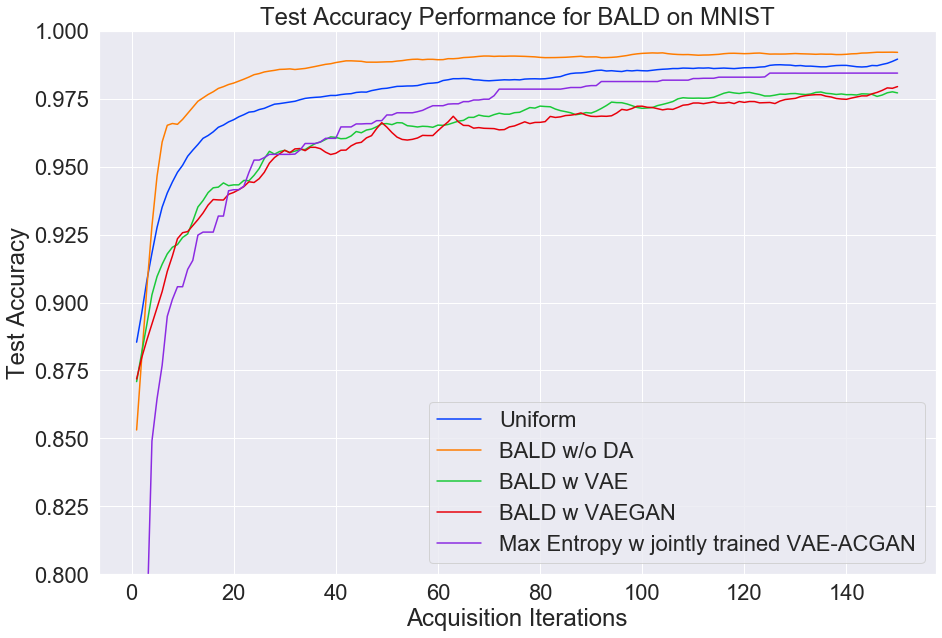

In [7]:
plot_mnist_bald("..\\MNIST")

In [8]:
def plot_mnist_uniform(mnist_plots_location):
    dirs = ["perf_lists_al", "perf_lists_vae", "perf_lists_vaegan"]
    labels = {
        "perf_lists_al": "Uniform w/o DA",
        "perf_lists_duplicate": "Uniform w Duplicated Samples",
        "perf_lists_vae": "Uniform w VAE",
        "perf_lists_vaegan": "Uniform w VAEGAN"
    }
    plt.tight_layout()
    plt.figure(figsize=(15, 10))
    plt.title("Test Accuracy Performance for Uniform on MNIST")
    plt.ylabel("Test Accuracy")
    plt.xlabel("Acquisition Iterations")
    
#     with open(os.path.join(mnist_plots_location, "perf_lists_al", "uniform_perf_hist")) as f:
#         uniform_val_accs = [float(line.rstrip()) for line in f]
#         no_x_vals = len(uniform_val_accs)
#         plt.plot(np.arange(no_x_vals), uniform_val_accs, label="Uniform")
    for dir_name in dirs:
        with open(os.path.join(mnist_plots_location, dir_name, "uniform_perf_hist")) as f:
            val_accs = [float(line.rstrip()) for line in f]
        no_x_vals = len(val_accs)-1
        val_accs_smoothen = savitzky_golay(np.array(val_accs[1:]), sg_window_size, sg_order)
        plt.plot(np.arange(no_x_vals)+1, val_accs_smoothen, label=labels[dir_name])
    plt.ylim([0.8, 1])
    plt.legend()
    plt.savefig(os.path.join(mnist_plots_location, "plots\\uniform.png"))

C:\Users\saumy\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\saumy\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.


<Figure size 432x288 with 0 Axes>

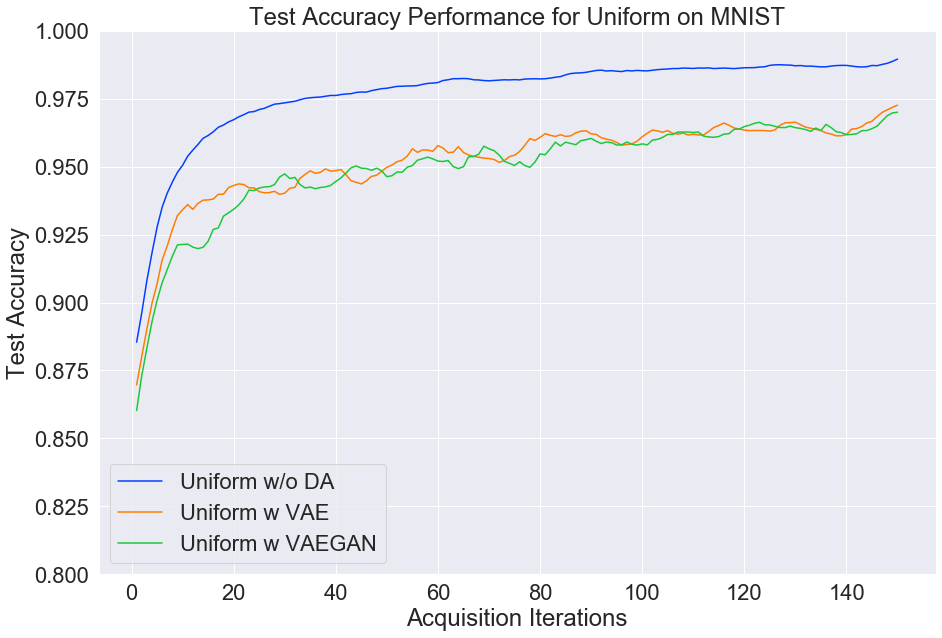

In [9]:
plot_mnist_uniform("..\\MNIST")